# **Laptop Price Prediction**

## **Can you predict the price of a laptop?**

**Content:**


*   Exploratory Data Analysis (EDA)
*   Feature Engineering
*   Feature Selection
*   Modeling
*   Hyperparameter Tuning





### **Dependencies**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from sklearn.preprocessing import  OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.metrics import mean_squared_error
import shap
import joblib
from google.colab import files
from scipy import stats

warnings.filterwarnings("ignore")

### **Load data**

In [2]:
df = pd.read_csv('laptop_prices.csv')

About the data:

*   Brand: The manufacturer of the laptop (e.g., Dell, HP, Apple, Asus, Lenovo).
*   Processor: The CPU model, including Intel (i3, i5, i7, i9) and AMD Ryzen (3, 5, 7, 9).
*   RAM (GB): The laptop's memory size (e.g., 4GB, 8GB, 16GB, 32GB, 64GB).
*   Storage: Type and size of storage (e.g., 256GB SSD, 512GB SSD, 1TB HDD).
*   GPU: The graphics processing unit, either integrated or dedicated (e.g., Nvidia GTX 1650, RTX 3060).
*   Screen Size (inch): The display size in inches (e.g., 13.3", 14", 15.6", 17.3").
*   Resolution: The screen resolution, such as 1366x768, 1920x1080, 2560x1440, or 3840x2160.
*   Battery Life (hours): Estimated battery life in hours, ranging from 4 to 12 hours.
*   Weight (kg): The weight of the laptop in kilograms, between 1.2kg and 3.5kg.
*   Operating System: The pre-installed OS, including Windows, macOS, Linux, and FreeDOS.
*   Price ($): The target variable, representing the laptop's price in US dollars.







### **Raw dataset overview**

In [ ]:
print('Dataset number of records: %s' % df.shape[0])
print('Dataset number of columns: %s' % df.shape[1])
df.head()

Dataset number of records: 11768
Dataset number of columns: 11


,Brand,Processor,RAM (GB),Storage,GPU,Screen Size (inch),Resolution,Battery Life (hours),Weight (kg),Operating System,Price ($)
0,Apple,AMD Ryzen 3,64,512GB SSD,Nvidia GTX 1650,17.3,2560x1440,8.9,1.42,FreeDOS,3997.07
1,Razer,AMD Ryzen 7,4,1TB SSD,Nvidia RTX 3080,14.0,1366x768,9.4,2.57,Linux,1355.78
2,Asus,Intel i5,32,2TB SSD,Nvidia RTX 3060,13.3,3840x2160,8.5,1.74,FreeDOS,2673.07
3,Lenovo,Intel i5,4,256GB SSD,Nvidia RTX 3080,13.3,1366x768,10.5,3.10,Windows,751.17
4,Razer,Intel i3,4,256GB SSD,AMD Radeon RX 6600,16.0,3840x2160,5.7,3.38,Linux,2059.83


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11768 entries, 0 to 11767
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Brand                 11768 non-null  object 
 1   Processor             11768 non-null  object 
 2   RAM (GB)              11768 non-null  int64  
 3   Storage               11768 non-null  object 
 4   GPU                   11768 non-null  object 
 5   Screen Size (inch)    11768 non-null  float64
 6   Resolution            11768 non-null  object 
 7   Battery Life (hours)  11768 non-null  float64
 8   Weight (kg)           11768 non-null  float64
 9   Operating System      11768 non-null  object 
 10  Price ($)             11768 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 1011.4+ KB


In [ ]:
df.describe()

,RAM (GB),Screen Size (inch),Battery Life (hours),Weight (kg),Price ($)
count,11768.000000,11768.000000,11768.000000,11768.000000,11768.000000
mean,24.852821,15.212305,8.027855,2.341117,2183.571608
std,21.762567,1.436997,2.305400,0.667921,1316.886132
min,4.000000,13.300000,4.000000,1.200000,279.570000
25%,8.000000,14.000000,6.000000,1.760000,1272.045000
50%,16.000000,15.600000,8.000000,2.340000,1840.865000
75%,32.000000,16.000000,10.000000,2.910000,2698.370000
max,64.000000,17.300000,12.000000,3.500000,10807.880000


In [ ]:
df.describe(include=['object'])

,Brand,Processor,Storage,GPU,Resolution,Operating System
count,11768,11768,11768,11768,11768,11768
unique,10,8,5,7,4,4
top,Apple,Intel i3,512GB SSD,Nvidia RTX 2060,3840x2160,Windows
freq,1262,1570,2420,1746,2977,2954


In [ ]:
df.isnull().sum()

,0
Brand,0
Processor,0
RAM (GB),0
Storage,0
GPU,0
Screen Size (inch),0
Resolution,0
Battery Life (hours),0
Weight (kg),0
Operating System,0


In [ ]:
df.nunique()

,0
Brand,10
Processor,8
RAM (GB),5
Storage,5
GPU,7
Screen Size (inch),5
Resolution,4
Battery Life (hours),81
Weight (kg),231
Operating System,4


In [ ]:
df.duplicated().any()

np.False_

Observations:


*   We don't have any missing values
*   There are no values less than or equal to 0.
*   We have enough values to work on our machine learning model



### **Exploratory Data Analysis (EDA)**

In [3]:
var_categorical = df.select_dtypes(include=['object']).columns
var_numerical = df.select_dtypes(include=np.number).columns.to_list()
print(f'numerical columns: {var_numerical}')
print(f'categorical columns: {var_categorical}')

numerical columns: ['RAM (GB)', 'Screen Size (inch)', 'Battery Life (hours)', 'Weight (kg)', 'Price ($)']
categorical columns: Index(['Brand', 'Processor', 'Storage', 'GPU', 'Resolution',
       'Operating System'],
      dtype='object')


### **Univariate analysis**

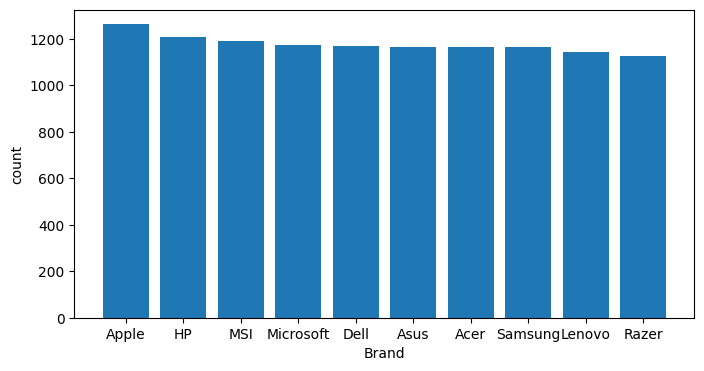

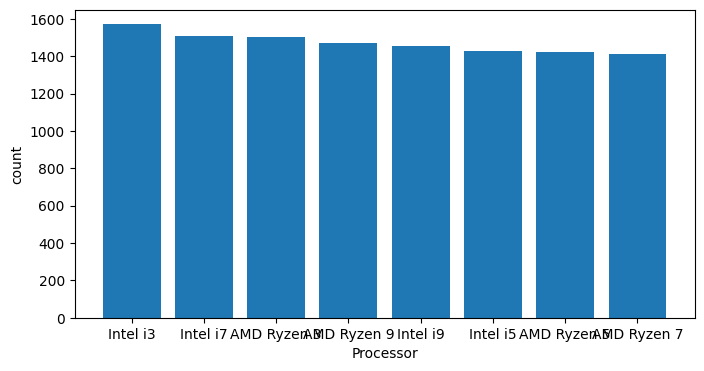

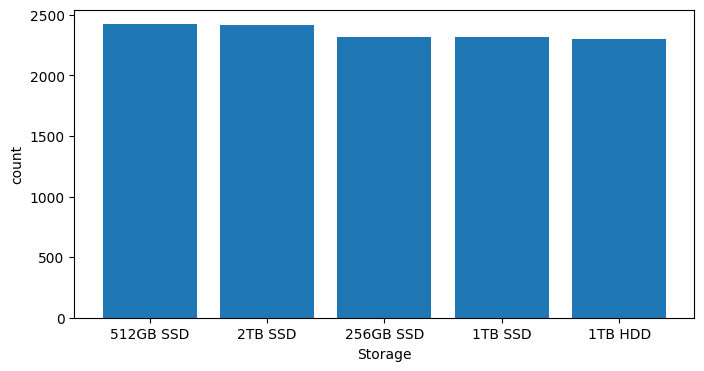

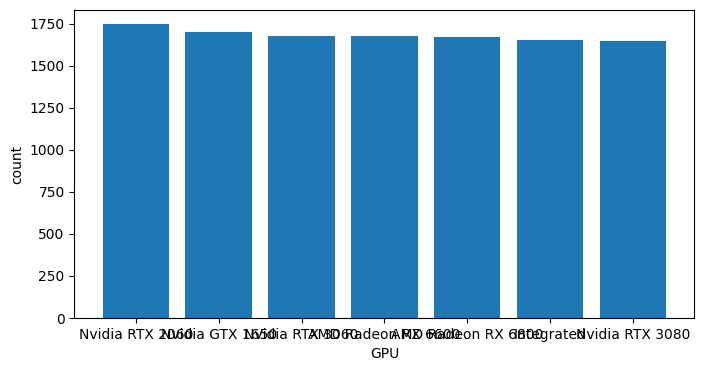

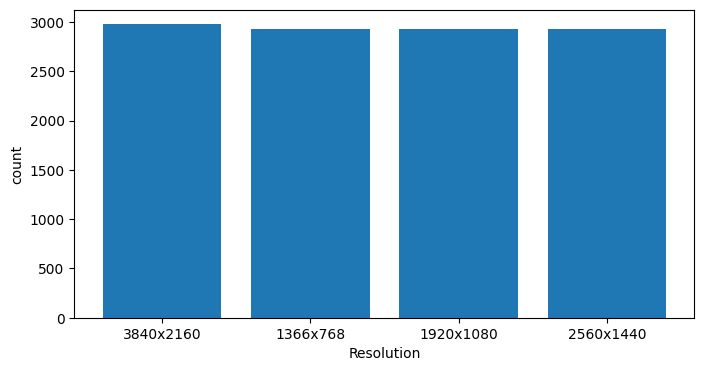

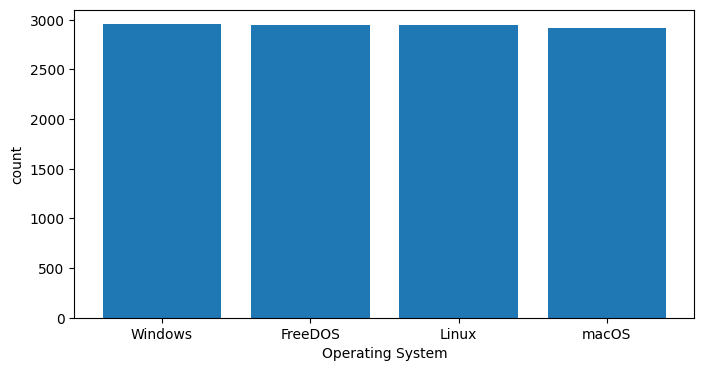

In [ ]:
for cat in var_categorical:
  plt.figure(figsize=(8,4))
  plt.bar(df[cat].value_counts().index, df[cat].value_counts().values)
  plt.xlabel(cat)
  plt.ylabel('count')
  plt.show()

Observations:

*   All the different categories are evenly distributed.


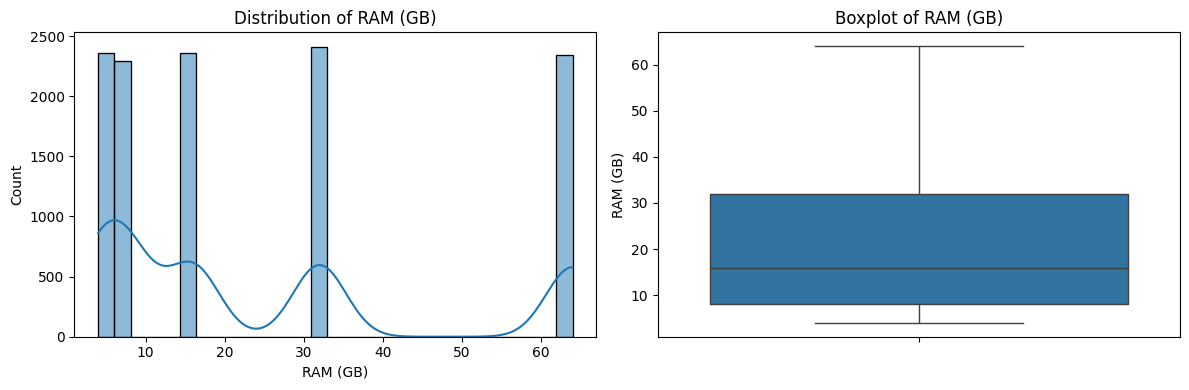

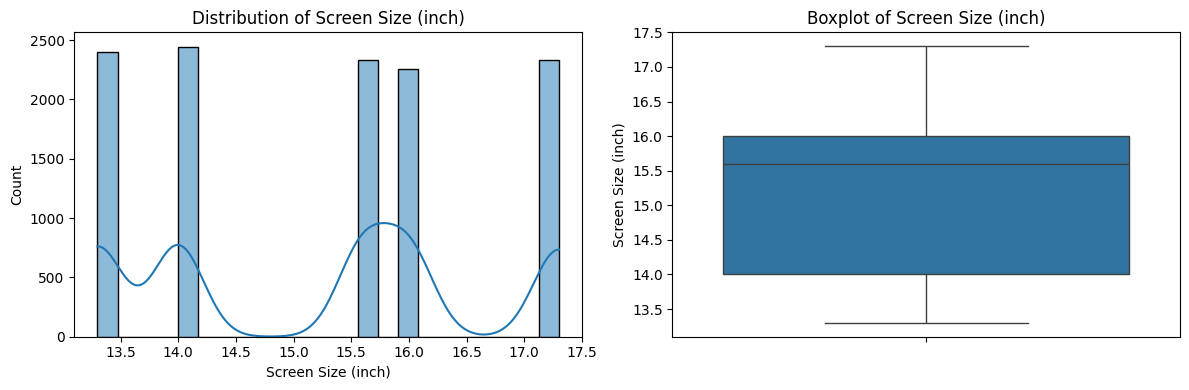

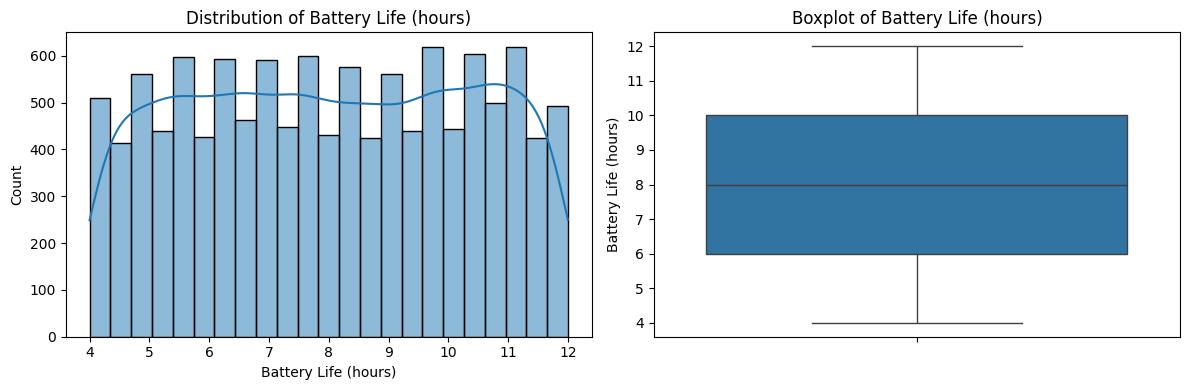

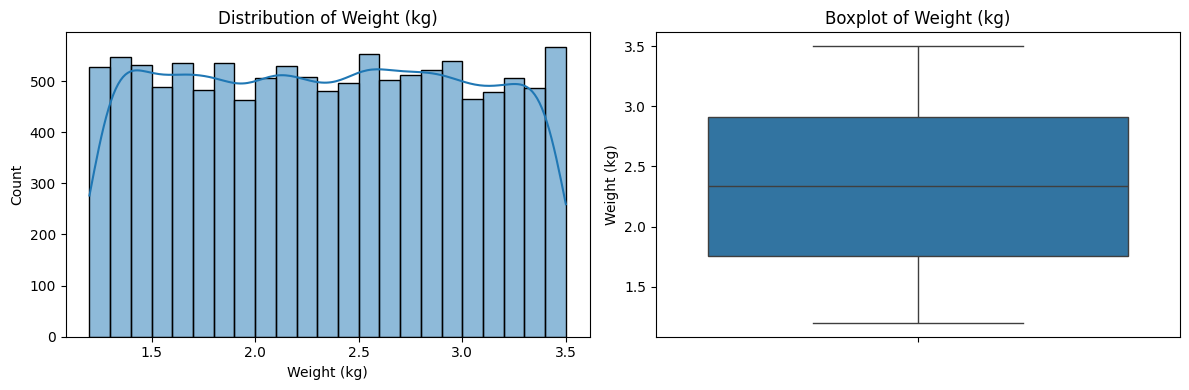

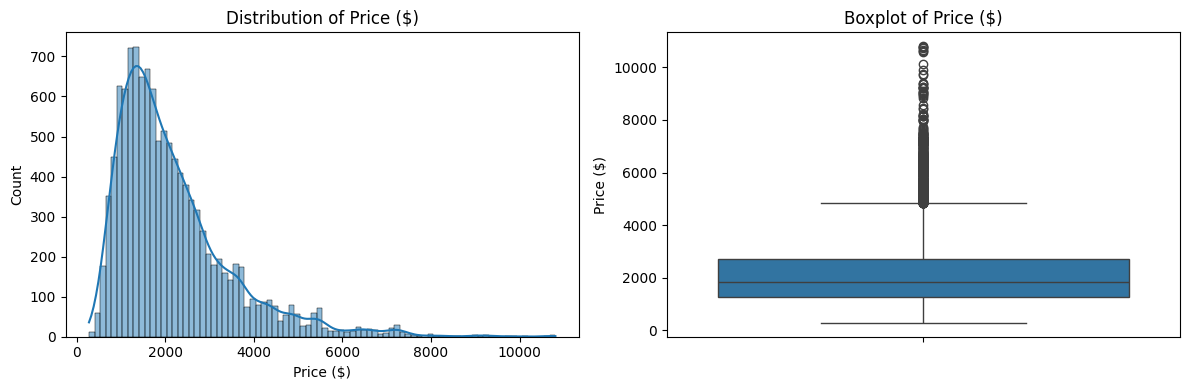

In [ ]:
figsize = (12, 4)

for num in var_numerical:
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    sns.histplot(df[num], kde=True, ax=axes[0])
    axes[0].set_ylabel('Count')
    axes[0].set_title(f'Distribution of {num}')
    sns.boxplot(df[num], ax=axes[1])
    axes[1].set_title(f'Boxplot of {num}')
    plt.tight_layout()
    plt.show()

Observations:


*   Outliers are only present in Price.
*   The average RAM is 24.8.
*   The average Screen Size is 15.2 inches.
*   The average Battery Life is 8 hours.
*   The average Weight is 2.3 kg
*   The average Price is $2183.5.





We will not remove the outliers from the price because they are important data for our model in this case

### **bivariate analysis**

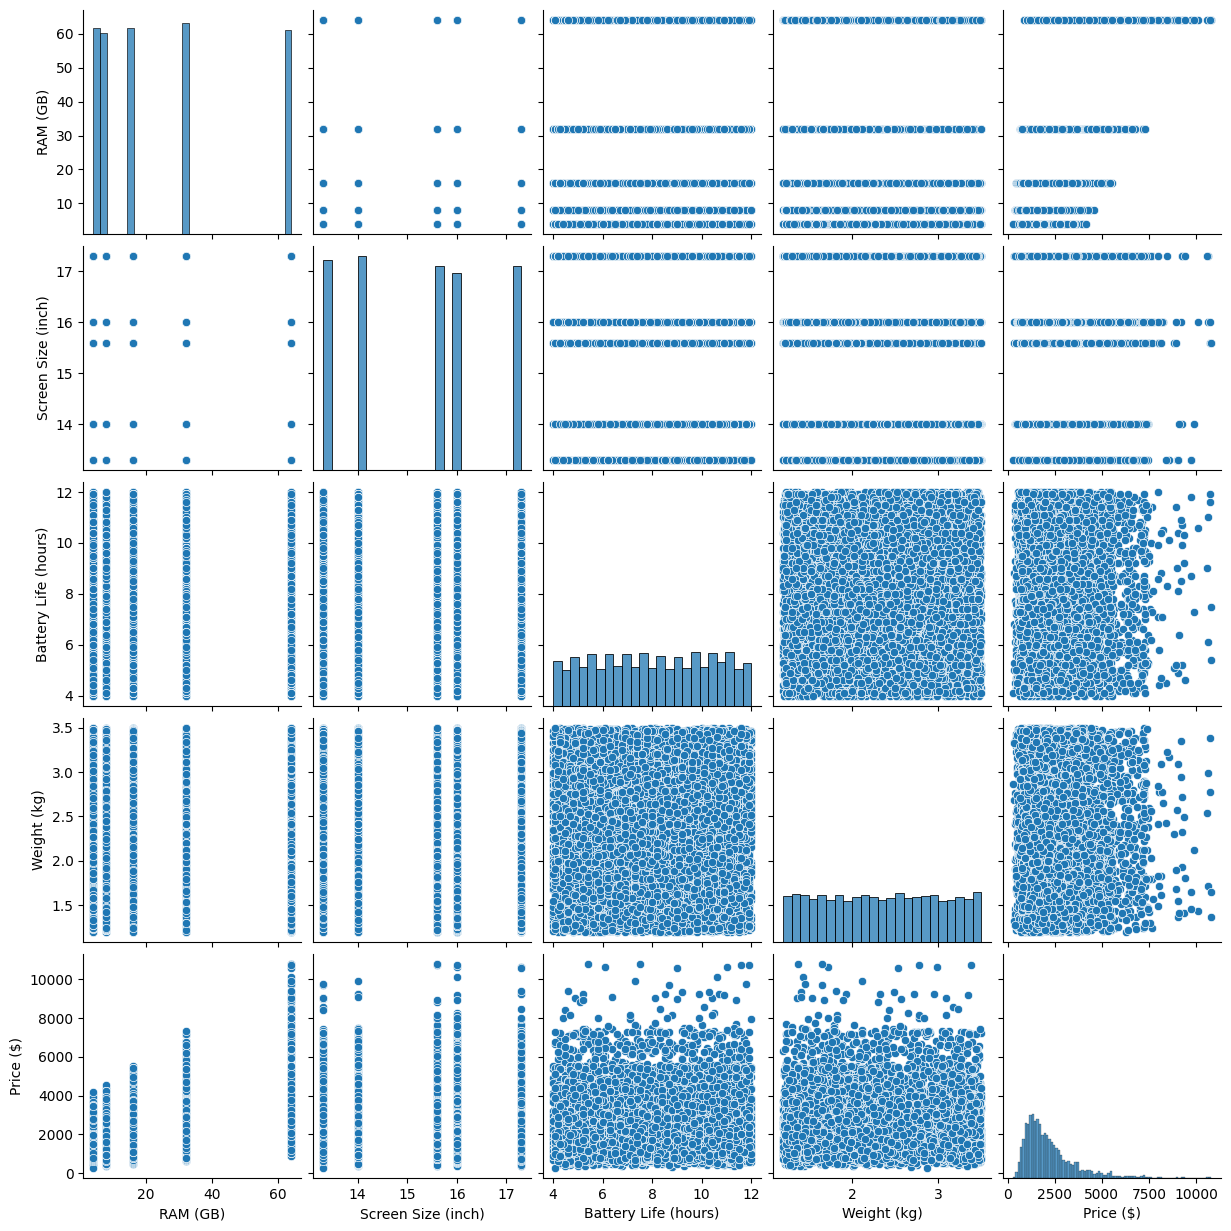

In [ ]:
sns.pairplot(df)

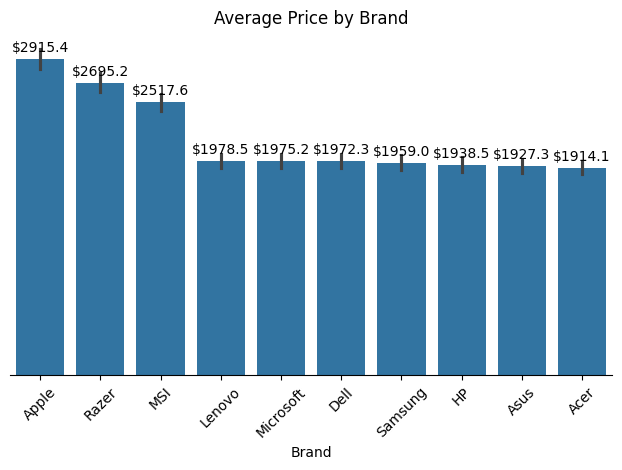

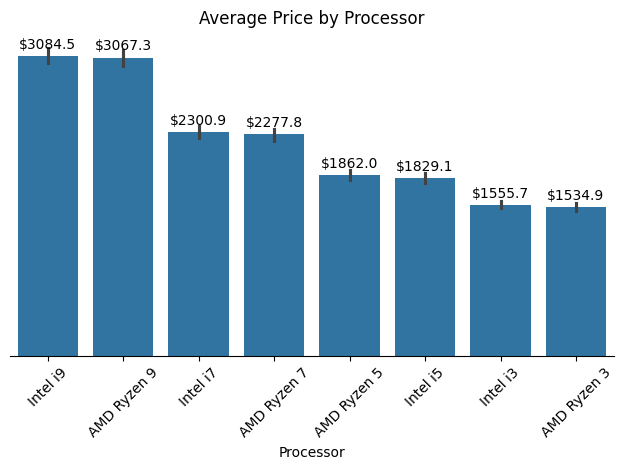

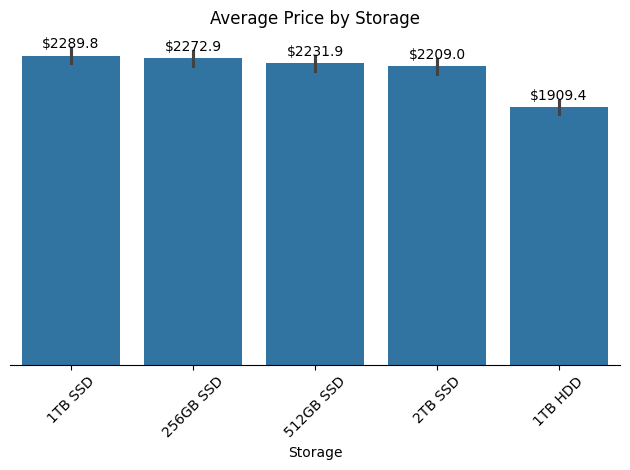

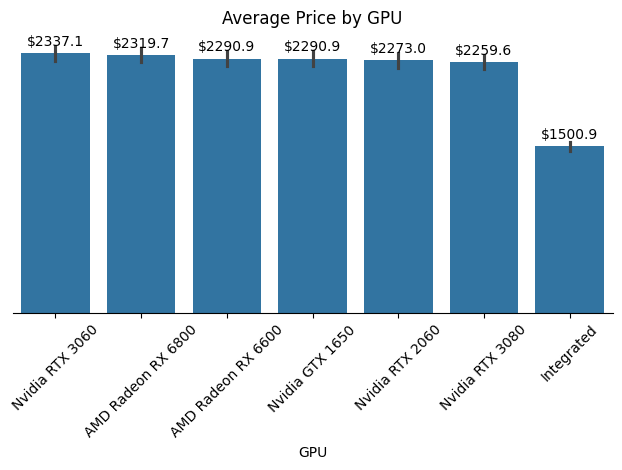

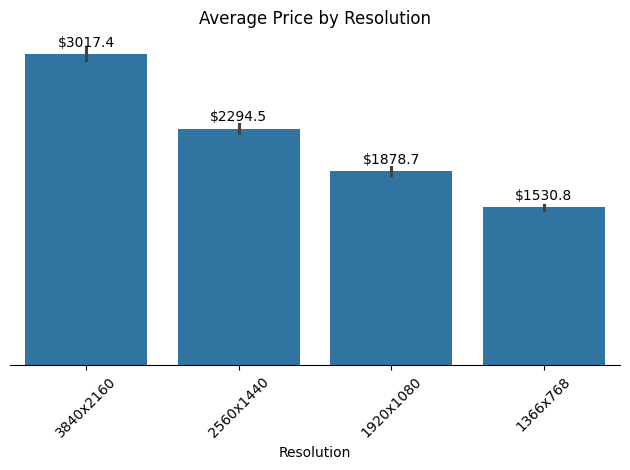

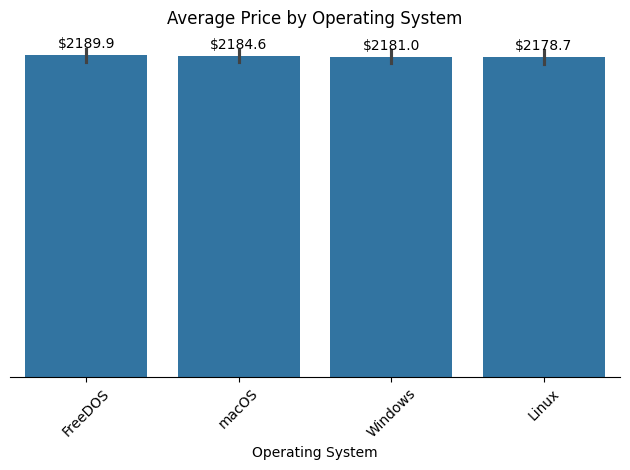

In [ ]:
for var in var_categorical:
  avg_prices = df.groupby(var)['Price ($)'].mean().sort_values(ascending=False).index
  ax = sns.barplot(x=var, y='Price ($)', data=df, order=avg_prices)
  for p in ax.patches:
    ax.annotate(f'${p.get_height():.1f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 8),
                textcoords='offset points')
  ax.spines['left'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.yaxis.set_visible(False)
  plt.title(f'Average Price by {var}')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

Observations:


*   The higher the RAM, the higher the price
*   Apple is the most expensive brand
*   If a computer has an Intel i9 or AMD Ryzen 9 processor, it is more expensive than the others.
*   If the computer has HDD storage, it is much cheaper, even if it has more memory.
*   If the GPU is integrated, the computer is worth less.
*   The higher the resolution, the higher the price.
*   There are no cost differences regarding the operating system.







### **Multivariate Analisys**

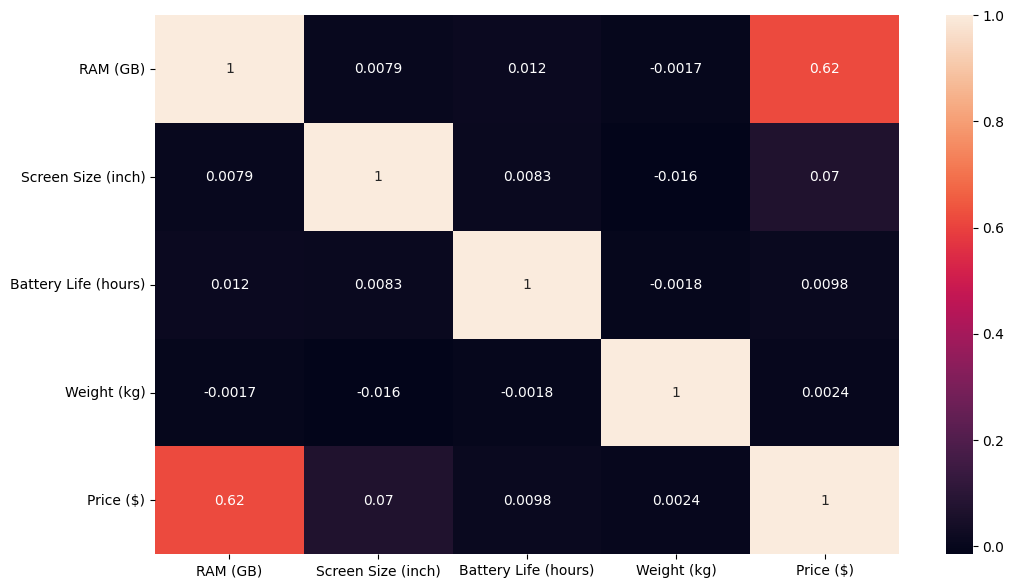

In [ ]:
df1=df.select_dtypes(exclude=['object'])
plt.figure(figsize=(12, 7))
sns.heatmap(df1.corr(),annot=True)
plt.show()

We can see that the feature with the highest correlation to price is RAM, so it will likely be very important when training the model.

### **Feature Engineering**

In [4]:
df[['Storage', 'Storage Type']] = df['Storage'].str.split(' ', expand=True)
df.head()

,Brand,Processor,RAM (GB),Storage,GPU,Screen Size (inch),Resolution,Battery Life (hours),Weight (kg),Operating System,Price ($),Storage Type
0,Apple,AMD Ryzen 3,64,512GB,Nvidia GTX 1650,17.3,2560x1440,8.9,1.42,FreeDOS,3997.07,SSD
1,Razer,AMD Ryzen 7,4,1TB,Nvidia RTX 3080,14.0,1366x768,9.4,2.57,Linux,1355.78,SSD
2,Asus,Intel i5,32,2TB,Nvidia RTX 3060,13.3,3840x2160,8.5,1.74,FreeDOS,2673.07,SSD
3,Lenovo,Intel i5,4,256GB,Nvidia RTX 3080,13.3,1366x768,10.5,3.10,Windows,751.17,SSD
4,Razer,Intel i3,4,256GB,AMD Radeon RX 6600,16.0,3840x2160,5.7,3.38,Linux,2059.83,SSD


In [5]:
def convert_to_gb(storage):
    if 'TB' in storage:
        size = float(storage.split('TB')[0].strip()) * 1024
    elif 'GB' in storage:
        size = float(storage.split('GB')[0].strip())
    return size

df['Storage'] = df['Storage'].apply(convert_to_gb)
df.head()

,Brand,Processor,RAM (GB),Storage,GPU,Screen Size (inch),Resolution,Battery Life (hours),Weight (kg),Operating System,Price ($),Storage Type
0,Apple,AMD Ryzen 3,64,512.0,Nvidia GTX 1650,17.3,2560x1440,8.9,1.42,FreeDOS,3997.07,SSD
1,Razer,AMD Ryzen 7,4,1024.0,Nvidia RTX 3080,14.0,1366x768,9.4,2.57,Linux,1355.78,SSD
2,Asus,Intel i5,32,2048.0,Nvidia RTX 3060,13.3,3840x2160,8.5,1.74,FreeDOS,2673.07,SSD
3,Lenovo,Intel i5,4,256.0,Nvidia RTX 3080,13.3,1366x768,10.5,3.10,Windows,751.17,SSD
4,Razer,Intel i3,4,256.0,AMD Radeon RX 6600,16.0,3840x2160,5.7,3.38,Linux,2059.83,SSD


In [ ]:
def split_resolution(resolution):
    width, height = resolution.split('x')
    return int(width), int(height)

df[['Width', 'Height']] = pd.DataFrame(df['Resolution'].apply(split_resolution).tolist(), index=df.index)
df.drop('Resolution', axis=1, inplace=True)
df.head()

,Brand,Processor,RAM (GB),Storage,GPU,Screen Size (inch),Battery Life (hours),Weight (kg),Operating System,Price ($),Storage Type,Width,Height
0,Apple,AMD Ryzen 3,64,512.0,Nvidia GTX 1650,17.3,8.9,1.42,FreeDOS,3997.07,SSD,2560,1440
1,Razer,AMD Ryzen 7,4,1024.0,Nvidia RTX 3080,14.0,9.4,2.57,Linux,1355.78,SSD,1366,768
2,Asus,Intel i5,32,2048.0,Nvidia RTX 3060,13.3,8.5,1.74,FreeDOS,2673.07,SSD,3840,2160
3,Lenovo,Intel i5,4,256.0,Nvidia RTX 3080,13.3,10.5,3.10,Windows,751.17,SSD,1366,768
4,Razer,Intel i3,4,256.0,AMD Radeon RX 6600,16.0,5.7,3.38,Linux,2059.83,SSD,3840,2160


In [ ]:
transformer = ColumnTransformer(transformers=[('onehot', OneHotEncoder(sparse_output=False), ['Brand', 'Processor', 'GPU', 'Operating System'])], remainder='passthrough')
transformed_data = transformer.fit_transform(df)

columns_encoded = [col.split('__')[-1] for col in transformer.get_feature_names_out()]
df_transformed = pd.DataFrame(transformed_data, columns=columns_encoded)
df_transformed.head()

,Brand_Acer,Brand_Apple,Brand_Asus,Brand_Dell,Brand_HP,Brand_Lenovo,Brand_MSI,Brand_Microsoft,Brand_Razer,Brand_Samsung,...,Operating System_macOS,RAM (GB),Storage,Screen Size (inch),Battery Life (hours),Weight (kg),Price ($),Storage Type,Width,Height
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,64,512.0,17.3,8.9,1.42,3997.07,SSD,2560,1440
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,4,1024.0,14.0,9.4,2.57,1355.78,SSD,1366,768
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,32,2048.0,13.3,8.5,1.74,2673.07,SSD,3840,2160
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,4,256.0,13.3,10.5,3.1,751.17,SSD,1366,768
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,4,256.0,16.0,5.7,3.38,2059.83,SSD,3840,2160


In [ ]:
le = LabelEncoder()
df_transformed['Storage Type'] = le.fit_transform(df['Storage Type'])
df_transformed.head()

,Brand_Acer,Brand_Apple,Brand_Asus,Brand_Dell,Brand_HP,Brand_Lenovo,Brand_MSI,Brand_Microsoft,Brand_Razer,Brand_Samsung,...,Operating System_macOS,RAM (GB),Storage,Screen Size (inch),Battery Life (hours),Weight (kg),Price ($),Storage Type,Width,Height
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,64,512.0,17.3,8.9,1.42,3997.07,1,2560,1440
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,4,1024.0,14.0,9.4,2.57,1355.78,1,1366,768
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,32,2048.0,13.3,8.5,1.74,2673.07,1,3840,2160
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,4,256.0,13.3,10.5,3.1,751.17,1,1366,768
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,4,256.0,16.0,5.7,3.38,2059.83,1,3840,2160


Perfect! Now that we have all the data cleaned and ready to work with, we are going to start building our machine learning model. But before that, we will analyze the correlation of the variables with the price again, as we were previously unable to see the correlation of our categorical variables with the price.

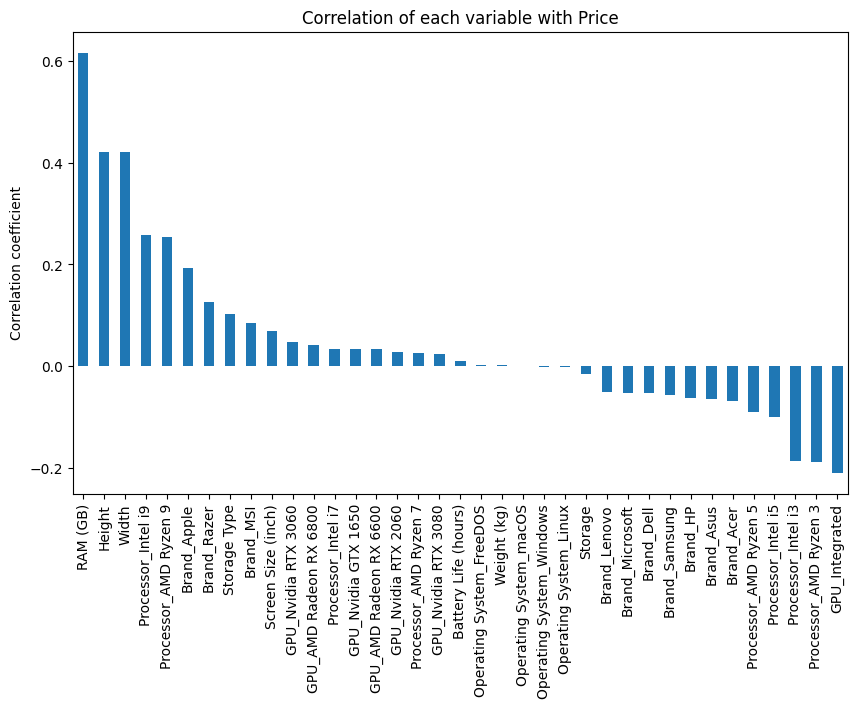

In [ ]:
corr_price = df_transformed.corr()['Price ($)'].sort_values(ascending=False)
plt.figure(figsize=(10,6))
corr_price.drop('Price ($)').plot(kind='bar')
plt.title('Correlation of each variable with Price')
plt.ylabel('Correlation coefficient')
plt.show()

We can see that, apart from RAM, height, width, and the i9 and AMD Ryzen 9 processors are highly correlated with price, unlike other variables. Additionally, the integrated GPU is negatively correlated with price. This was expected based on previous observations.

### **Modeling**

First, we are going to find which model predicts our data best.

In this case, we are going to use MSE as the metric to evaluate the models.

In [ ]:
def get_models():
    models, names = list(), list()
    models.append(LinearRegression())
    names.append('LR')
    models.append(xgb.XGBRegressor())
    names.append('XGB')
    models.append(SVR())
    names.append('SVM')
    models.append(RandomForestRegressor())
    names.append('RFR')
    return models, names

def evaluate_model(X, y, model):
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    return scores

scaler = StandardScaler()
X = df_transformed.drop('Price ($)', axis=1)
y = df_transformed['Price ($)']
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)

models, names = get_models()
results = list()

for i in range(len(models)):
  scores = evaluate_model(df_scaled, y, models[i])
  results.append(scores)
  print('>%s %.3f (%.3f)' % (names[i], abs(np.mean(scores)), np.std(scores)))

>LR 205882.804 (14481.519)
>XGB 18016.787 (1443.719)
>SVM 1668891.739 (81361.402)
>RFR 42887.909 (6117.408)


We can see that XGB Regressor makes the best predictions by far. Now, we are going to check if the results improve by training XGB Regressor and Random Forest Regressor with the unscaled data.

In [ ]:
def get_models():
    models, names = list(), list()
    models.append(xgb.XGBRegressor())
    names.append('XGB')
    models.append(RandomForestRegressor())
    names.append('RFR')
    return models, names

def evaluate_model(X, y, model):
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    return scores

df_transformed = df_transformed.astype(float)
X = df_transformed.drop('Price ($)', axis=1)
y = df_transformed['Price ($)']

models, names = get_models()
results = list()

for i in range(len(models)):
  scores = evaluate_model(X, y, models[i])
  results.append(scores)
  print('>%s %.3f (%.3f)' % (names[i], abs(np.mean(scores)), np.std(scores)))

>XGB 18016.786 (1443.719)
>RFR 43157.043 (5687.254)


We can see that there is no significant difference in the results of the unscaled models.

Now, we are going to find the best hyperparameters for the models to see if we can achieve better results, excluding the Linear Regression model, as there aren’t many hyperparameters to tune.

In [ ]:
def tune_model_random(model, param_dist, X, y, n_iter=50):
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1,
        n_iter=n_iter,
        random_state=42
    )
    random_search.fit(X, y)
    print(f"Best parameters for {model} are {random_search.best_params_} and its best MSE is {abs(random_search.best_score_):.2f}")
    return random_search.best_estimator_

param_grid_xgb = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

param_grid_svr = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2, 0.5],
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}

param_grid_rfr = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

best_xgb_random = tune_model_random(xgb.XGBRegressor(), param_grid_xgb, df_scaled, y)
best_rfr_random = tune_model_random(RandomForestRegressor(), param_grid_rfr, df_scaled, y)
best_svr_random = tune_model_random(SVR(), param_grid_svr, df_scaled, y)


Best parameters for XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) are {'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.7} and its best MSE is 13999.40
Best parameters for RandomForestRegressor() are {'n_estimat

XGB Regressor is still the model that gives us the lowest error by far. Let's see if we can improve it even further.

In [ ]:
def tune_model_hyperopt(X, y, max_evals=50):
    space = {
        'n_estimators': hp.choice('n_estimators', [50, 100, 200, 300]),
        'max_depth': hp.quniform('max_depth', 3, 10, 1),
        'learning_rate': hp.loguniform('learning_rate', -4, -1),
        'subsample': hp.choice('subsample', [0.5, 0.7, 1.0]),
        'colsample_bytree': hp.choice('colsample_bytree', [0.5, 0.7, 1.0]),
        'reg_alpha': hp.choice('reg_alpha', [0, 0.1, 1]),
        'reg_lambda': hp.choice('reg_lambda', [1, 1.5, 2])
    }

    def objective(params):
        params['max_depth'] = int(params['max_depth'])
        model = xgb.XGBRegressor(**params)
        score = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1).mean()
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
    best['n_estimators'] = [50, 100, 200, 300][best['n_estimators']]
    best['subsample'] = [0.5, 0.7, 1.0][best['subsample']]
    best['colsample_bytree'] = [0.5, 0.7, 1.0][best['colsample_bytree']]
    best['reg_alpha'] = [0, 0.1, 1][best['reg_alpha']]
    best['reg_lambda'] = [1, 1.5, 2][best['reg_lambda']]
    best['max_depth'] = int(best['max_depth'])

    print(f"Best parameters of XGB with Hyperopt: {best}")

    best_model = xgb.XGBRegressor(**best)
    best_model.fit(X, y)
    return best_model

best_xgb_hyperopt = tune_model_hyperopt(df_scaled, y, max_evals=200)


100%|██████████| 200/200 [10:08<00:00,  3.04s/trial, best loss: 12653.0154296875]
Best parameters of XGB with Hyperopt: {'colsample_bytree': 1.0, 'learning_rate': np.float64(0.04813884589930396), 'max_depth': 6, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.7}


Now that we have improved its results a bit more, let's split the data and see which features it assigns the most weight to.

In [ ]:
scaler = StandardScaler()
X = df_transformed.drop('Price ($)', axis=1)
y = df_transformed['Price ($)']
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_scaled, y, test_size=0.2, random_state=42)
model = xgb.XGBRegressor(colsample_bytree=1.0, learning_rate=0.04203229519071702, max_depth=6, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}, RMSE: {np.sqrt(mse)}")

Mean Squared Error (MSE): 12290.4931640625, RMSE: 110.86249665266654


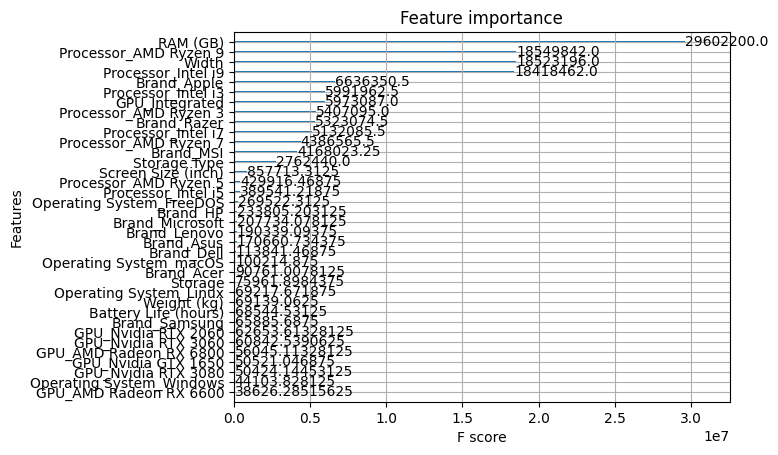

In [ ]:
xgb.plot_importance(model, importance_type="gain")
plt.show()

 98%|===================| 2302/2354 [00:39<00:00]       

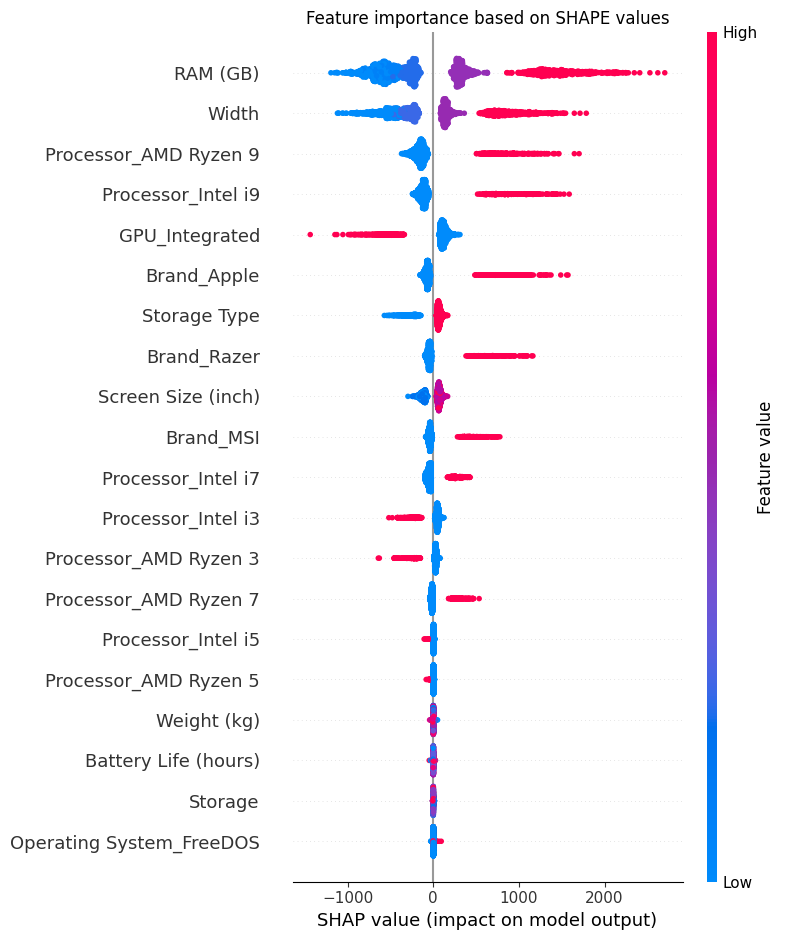

In [ ]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
plt.title('Feature importance based on SHAPE values')
shap.summary_plot(shap_values, X_test)

We can see that RAM, Intel and Ryzen processors, and width were the features assigned the most weight.

Now, let's see if reducing the number of features improves the model's performance.

In [ ]:
selector = RFE(model, n_features_to_select=15, step=1)
selector.fit(X_train, y_train)

selected_features = X_train.columns[selector.support_]
print("Selected features:", selected_features)

Selected features: Index(['Brand_Apple', 'Brand_MSI', 'Brand_Razer', 'Processor_AMD Ryzen 3',
       'Processor_AMD Ryzen 5', 'Processor_AMD Ryzen 7',
       'Processor_AMD Ryzen 9', 'Processor_Intel i3', 'Processor_Intel i5',
       'Processor_Intel i7', 'Processor_Intel i9', 'GPU_Integrated',
       'RAM (GB)', 'Storage Type', 'Width'],
      dtype='object')


In [ ]:
selected_features = df_transformed[selected_features.tolist()]
X_train, X_test, y_train, y_test = train_test_split(selected_features, y, test_size=0.2, random_state=42)
model = xgb.XGBRegressor(colsample_bytree=1.0, learning_rate=0.04203229519071702, max_depth=6, n_estimators=300, reg_alpha=0, reg_lambda=2, subsample=0.7)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}, RMSE: {np.sqrt(mse)}")

Mean Squared Error (MSE): 24076.388359523495, RMSE: 155.16568035336775


In [ ]:
best_xgb_hyperopt2 = tune_model_hyperopt(selected_features, y, max_evals=200)

 95%|█████████▌| 190/200 [04:04<00:14,  1.49s/trial, best loss: 23399.935115751436]

We see that reducing the features gives us a much worse result (I tested different numbers of features for the model), so in this case, we will stick with all the features we had previously.

**This code was used for Streamlit**

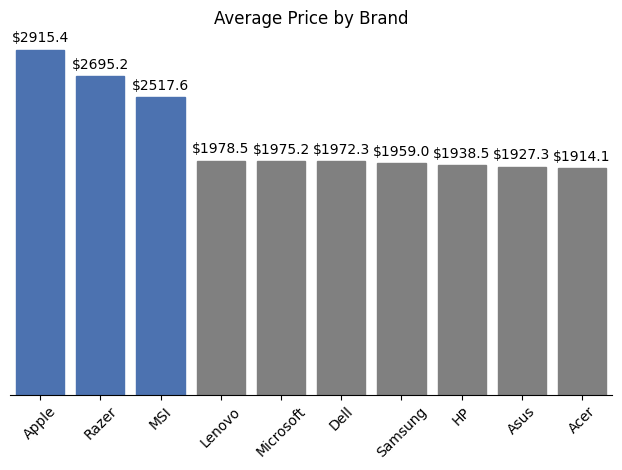

In [4]:
avg_prices = df.groupby('Brand')['Price ($)'].mean().sort_values(ascending=False).index
ax = sns.barplot(x='Brand', y='Price ($)', data=df, order=avg_prices, ci=None)

for i, p in enumerate(ax.patches):
    if i < 3:
        p.set_color("#4c72b0")
    else:
        p.set_color("gray")

for p in ax.patches:
  ax.annotate(f'${p.get_height():.1f}',
              (p.get_x() + p.get_width() / 2., p.get_height()),
              ha='center', va='center',
              xytext=(0, 8),
              textcoords='offset points')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.yaxis.set_visible(False)
plt.title(f'Average Price by Brand')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
overall_avg = df["Price ($)"].mean()
apple_avg = df[df["Brand"] == "Apple"]["Price ($)"].mean()

percentage_above = ((apple_avg - overall_avg) / overall_avg) * 100
print(f"The average price of Apple is {percentage_above:.2f}% above the market average.")

The average price of Apple is 33.51% above the market average.


In [6]:
apple_prices = df[df["Brand"] == "Apple"]["Price ($)"]
non_apple_prices = df[df["Brand"] != "Apple"]["Price ($)"]

t_stat, p_value = stats.ttest_ind(apple_prices, non_apple_prices, equal_var=False)

print(f"t-statistic: {t_stat:.6f}")
print(f"p-value: {p_value:.6f}")

if p_value < 0.05:
    print("The difference is statistically significant.")
else:
    print("No statistically significant difference was found.")


t-statistic: 16.449022
p-value: 0.000000
The difference is statistically significant.


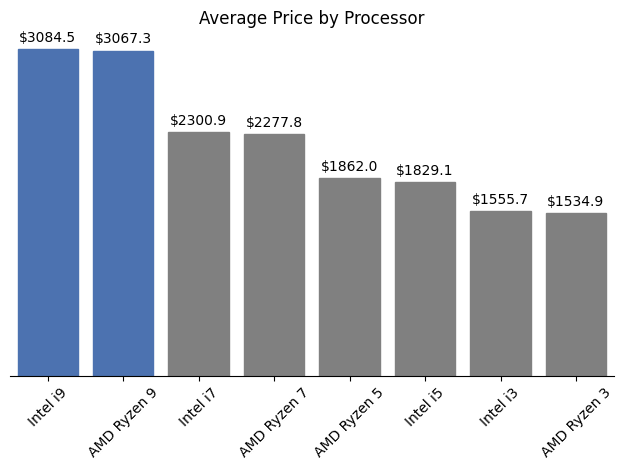

In [8]:
avg_prices = df.groupby('Processor')['Price ($)'].mean().sort_values(ascending=False).index
ax = sns.barplot(x='Processor', y='Price ($)', data=df, order=avg_prices, ci=None)

for i, p in enumerate(ax.patches):
    if i < 2:
        p.set_color("#4c72b0")
    else:
        p.set_color("gray")

for p in ax.patches:
  ax.annotate(f'${p.get_height():.1f}',
              (p.get_x() + p.get_width() / 2., p.get_height()),
              ha='center', va='center',
              xytext=(0, 8),
              textcoords='offset points')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.yaxis.set_visible(False)
plt.title(f'Average Price by Processor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
mean_i9 = df[df['Processor'] == 'Intel i9']['Price ($)'].mean()
mean_ryzen9 = df[df['Processor'] == 'AMD Ryzen 9']['Price ($)'].mean()

pct_diff_i9 = ((mean_i9 - overall_avg) / overall_avg) * 100
pct_diff_ryzen9 = ((mean_ryzen9 - overall_avg) / overall_avg) * 100

print(f"Intel i9 is {pct_diff_i9:.2f}% above the overall processor price average.")
print(f"AMD Ryzen 9 is {pct_diff_ryzen9:.2f}% above the overall processor price average.")

Intel i9 is 41.26% above the overall processor price average.
AMD Ryzen 9 is 40.47% above the overall processor price average.


In [10]:
prices_i9 = df[df['Processor'] == 'Intel i9']['Price ($)']
prices_others = df[df['Processor'] != 'Intel i9']['Price ($)']
t_stat_i9, p_val_i9 = stats.ttest_ind(prices_i9, prices_others, equal_var=False)
print(f"Intel i9 t-stat: {t_stat_i9:.3f}, p-value: {p_val_i9:.3f}")

prices_ryzen9 = df[df['Processor'] == 'AMD Ryzen 9']['Price ($)']
prices_others = df[df['Processor'] != 'AMD Ryzen 9']['Price ($)']
t_stat_ryzen, p_val_ryzen = stats.ttest_ind(prices_ryzen9, prices_others, equal_var=False)
print(f"AMD Ryzen 9 t-stat: {t_stat_ryzen:.3f}, p-value: {p_val_ryzen:.3f}")

Intel i9 t-stat: 23.609, p-value: 0.000
AMD Ryzen 9 t-stat: 22.827, p-value: 0.000


In [11]:
avg_prices = df.groupby('Processor')['Price ($)'].mean().sort_values(ascending=False)
avg_prices

,Price ($)
Processor,
Intel i9,3084.511834
AMD Ryzen 9,3067.286753
Intel i7,2300.938979
AMD Ryzen 7,2277.774418
AMD Ryzen 5,1862.017925
Intel i5,1829.125983
Intel i3,1555.673013
AMD Ryzen 3,1534.919567


In [13]:
integrated_avg = df[df["GPU"] == "Integrated"]["Price ($)"].mean()

percentage_above = ((integrated_avg - overall_avg) / overall_avg) * 100
print(f"The average price of an integrated GPU is {abs(percentage_above):.2f}% below the market average.")

The average price of an integrated GPU is 31.26% below the market average.


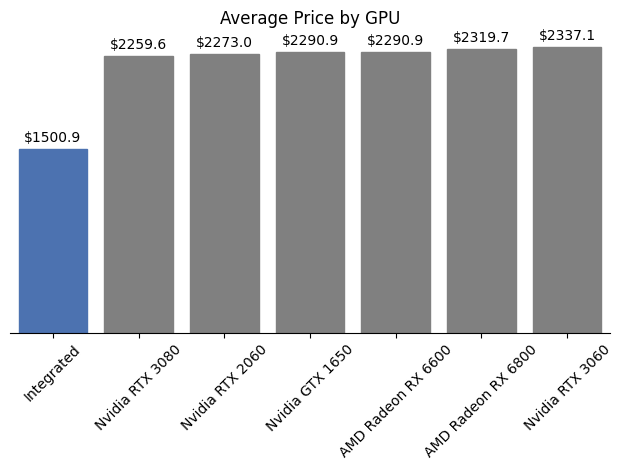

In [14]:
avg_prices = df.groupby('GPU')['Price ($)'].mean().sort_values().index
ax = sns.barplot(x='GPU', y='Price ($)', data=df, order=avg_prices, ci=None)

for i, p in enumerate(ax.patches):
    if i < 1:
        p.set_color("#4c72b0")
    else:
        p.set_color("gray")

for p in ax.patches:
  ax.annotate(f'${p.get_height():.1f}',
              (p.get_x() + p.get_width() / 2., p.get_height()),
              ha='center', va='center',
              xytext=(0, 8),
              textcoords='offset points')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.yaxis.set_visible(False)
plt.title(f'Average Price by GPU')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

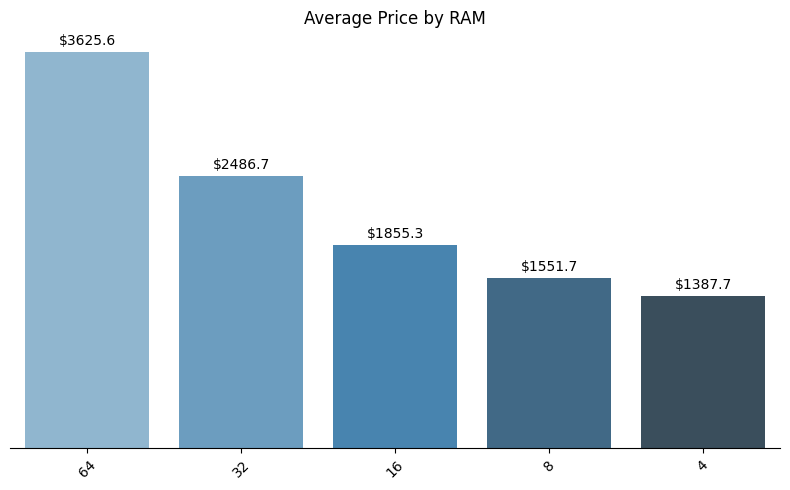

In [15]:
ram_avg = df.groupby("RAM (GB)")["Price ($)"].mean().reset_index()
ram_avg = ram_avg.sort_values(by="Price ($)", ascending=False)

plt.figure(figsize=(8,5))
ax = sns.barplot(x="RAM (GB)", y="Price ($)", data=ram_avg, palette="Blues_d", order=ram_avg["RAM (GB)"])
for p in ax.patches:
  ax.annotate(f'${p.get_height():.1f}',
              (p.get_x() + p.get_width() / 2., p.get_height()),
              ha='center', va='center',
              xytext=(0, 8),
              textcoords='offset points')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.yaxis.set_visible(False)
plt.title(f'Average Price by RAM')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

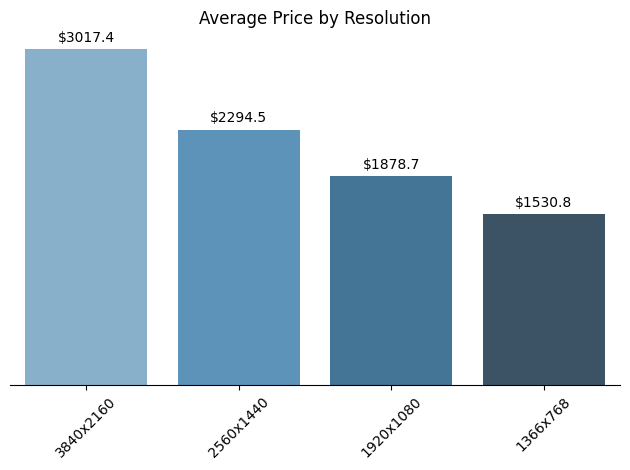

In [16]:
avg_prices = df.groupby('Resolution')['Price ($)'].mean().sort_values(ascending=False).index
ax = sns.barplot(x='Resolution', y='Price ($)', data=df, order=avg_prices, palette="Blues_d", ci=None)

for p in ax.patches:
  ax.annotate(f'${p.get_height():.1f}',
              (p.get_x() + p.get_width() / 2., p.get_height()),
              ha='center', va='center',
              xytext=(0, 8),
              textcoords='offset points')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.yaxis.set_visible(False)
plt.title(f'Average Price by Resolution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
integrated_avg = df[df["Resolution"] == "3840x2160"]["Price ($)"].mean()

percentage_above = ((integrated_avg - overall_avg) / overall_avg) * 100
print(f"The average price of the 3840x2160 resolution is {percentage_above:.2f}% above the market average.")

The average price of the 3840x2160 resolution is 38.19% above the market average.
